## Final Modeling

In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [131]:
import os
import sys
HOME_DIR = '/home/aysola/'
os.chdir(HOME_DIR)
sys.path.append('./NVFEL498/')

In [132]:
from sklearn.linear_model import LinearRegression

In [133]:
from Notebooks.utils import *

In [330]:
ice_data = pd.read_csv('./NVFEL498/all_ICE_trips.csv')
hev_data = pd.read_csv('./NVFEL498/all_HEV_trips_vel.csv')
hev_500_data = pd.read_csv('./NVFEL498/500_HEV_trips_vel.csv')

In [331]:
def nan_check(data):
    mask = [~(np.isnan(data.iloc[i,:]).sum()>0) for i in range(len(data))]
    data = data.loc[mask]
    return data

In [332]:
ice_data = nan_check(ice_data)

In [334]:
hev_data = nan_check(hev_data)

In [333]:
hev_500_data = nan_check(hev_500_data)

In [335]:
ice_data.head()

,TripId,TripId_raw,VehId,Aggressivity,Aggressiveness,Distance[km],Fuel Consumed[L],Fuel Rate[gpm],Weight,Displacement,SpeedAverage,SpeedVariance,Air Temperature[F],Precipitation Level[mm]
0,0,2265,123,475.645508,5748.696207,9.225222,0.895646,0.097087,2500.0,1.8,46.423729,147.494133,6.40,0.0
1,1,1239,135,269.540959,6372.966896,2.223611,0.441901,0.198731,3500.0,2.5,40.748170,447.766401,-6.47,0.0
2,4,2263,575,266.112770,5665.167276,6.323556,1.008958,0.159556,4000.0,2.4,32.929095,247.070941,1.52,0.0
3,7,1681,522,552.585767,5891.611649,2.743222,0.344075,0.125427,3000.0,2.4,33.915000,447.276871,8.92,0.0
4,8,1375,250,529.245807,5535.915731,4.683417,0.937469,0.200168,5500.0,5.3,33.196768,319.067811,12.23,0.0


In [336]:
hev_data.head()

,Unnamed: 0,Unnamed: 0.1,TripId,TripId_raw,VehId,Aggressiveness,Distance[km],Fuel Consumed[L],Fuel Rate[gpm],Weight,Displacement,SpeedAverage,SpeedVariance
0,0,0,0,918,392,1.984394e+06,4.012389,0.610966,0.152270,4500,3.5,41.194529,287.675458
1,1,1,1,1736,450,1.772270e+06,2.972750,0.164877,0.055463,3500,1.8,38.202231,339.225944
2,2,2,2,854,418,9.148367e+05,2.590917,0.208584,0.080506,3000,1.8,34.942029,642.839653
3,3,3,3,1240,468,2.523084e+06,5.838583,0.458996,0.078614,3500,1.8,54.502618,294.975059
4,4,4,4,2320,565,4.192641e+06,11.211139,0.647774,0.057779,2500,1.3,27.558642,203.199029


In [337]:
hev_500_data.head()

,Unnamed: 0,Unnamed: 0.1,TripId,TripId_raw,VehId,Aggressiveness,Distance[km],Fuel Consumed[L],Fuel Rate[gpm],Weight,Displacement,SpeedAverage,SpeedVariance
0,0,0,9,3265,125,5906.293170,1.447778,0.170529,0.117787,3500,2.4,42.135309,327.985539
1,1,1,13,872,474,6409.282861,2.190417,0.197069,0.089969,3000,1.5,50.044444,130.991649
2,2,2,34,1869,231,5199.283589,1.969694,0.167685,0.085132,3000,1.8,50.975376,333.922681
3,3,3,55,1045,375,4243.048928,11.787750,1.873659,0.158950,4500,3.3,29.327434,191.811473
4,4,4,61,767,458,4326.967848,1.825528,0.192831,0.105630,3500,2.4,25.423256,348.803184


In [338]:
ice_data.shape

(11529, 14)

In [339]:
hev_data.shape

(9192, 13)

In [340]:
hev_500_data.shape

(501, 13)

In [341]:
cols = ["Aggressiveness", "Distance[km]", "Weight", "Displacement", "SpeedAverage", "SpeedVariance"]
features = cols.copy()
for i in range(len(cols)):
    for j in range(i, len(cols)):
        features.append(f"{cols[i]}*{cols[j]}")
        features.append(f"{cols[i]}/{cols[j]}")


In [342]:
# features = [
#     "Weight",
#     "Displacement",
#     "Aggressiveness",
#     "SpeedAverage",
#     "Aggressiveness*SpeedAverage",
#     "Aggressiveness*Weight",
#     "Aggressiveness*Displacement",
#     "Displacement/Weight"
# ]

In [343]:
def transform_data(data, features, out = 'Fuel Rate[gpm]'):
    d = pd.DataFrame(columns = features)
    
    for f in features:
        if '*' in f:
            f1, f2 = f.split('*')
            d[f] = data[f1] * data[f2]
        elif '/' in f:
            f1, f2 = f.split('/')
            d[f] = data[f1] / data[f2]
        else:
            d[f] = data[f]
            
    return np.array(d), np.array(data[out]), {f:i for i,f in enumerate(features)}

In [362]:
X, y, features = transform_data(hev_data, features)

In [325]:
X[np.isnan(X)] = 0
X[X==float('inf')]=0

In [326]:
X.shape

(9192, 48)

In [327]:
model = LinearRegression().fit(X,y)

In [328]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(features.keys(), model.coef_)):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_)])
for feature, i in zip(features.keys(), (impact*100)/impact.sum()):
    if i >= 1 print(f"{feature}: {i}")

Impact = MEAN * Coef
Aggressiveness: -0.014312132163760033
Distance[km]: 0.023697949552599788
Weight: -0.7860686841516241
Displacement: 0.7555422166304622
SpeedAverage: 0.00039945696045193567
SpeedVariance: -0.002461181053171982
Aggressiveness*Aggressiveness: 0.001921741949679293
Aggressiveness/Aggressiveness: 2.095543182132763e-07
Aggressiveness*Distance[km]: -0.0008212245757463738
Aggressiveness/Distance[km]: 0.012682043822991368
Aggressiveness*Weight: 4.644978526810908e-05
Aggressiveness/Weight: -0.006664103869558674
Aggressiveness*Displacement: 0.000101473449091338
Aggressiveness/Displacement: 0.011471243740807992
Aggressiveness*SpeedAverage: -5.3277142345735275e-05
Aggressiveness/SpeedAverage: 0.0014866350838894033
Aggressiveness*SpeedVariance: 0.0007223994587001986
Aggressiveness/SpeedVariance: 0.0004737784013450895
Distance[km]*Distance[km]: -8.30417161612813e-06
Distance[km]/Distance[km]: 2.6077737191876338e-11
Distance[km]*Weight: -0.007067933549990914
Distance[km]/Weight: 6.6

In [329]:
# now lets compute r^2:
# WOW WE have an almost 0 impact on r^2 -- surprising
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()
print(r_2)

0.24125288096041575


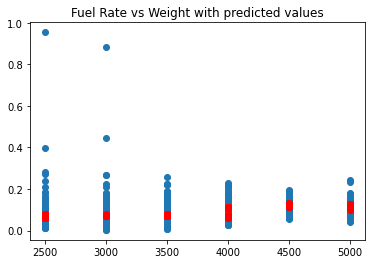

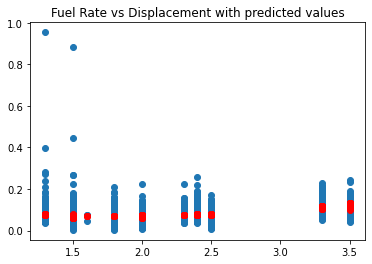

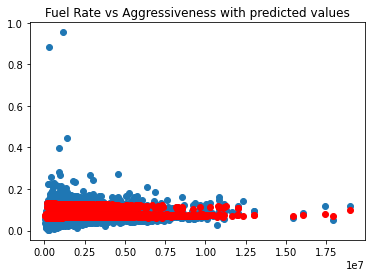

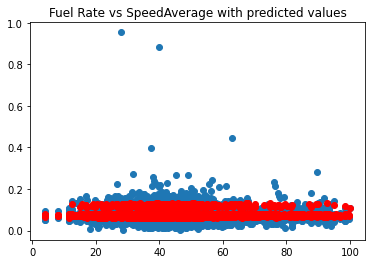

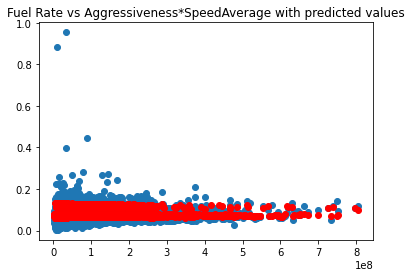

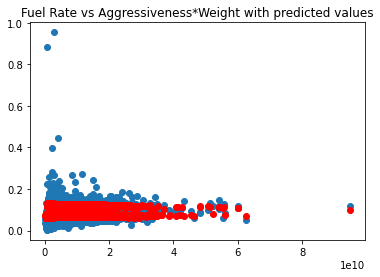

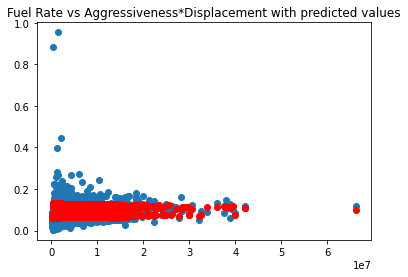

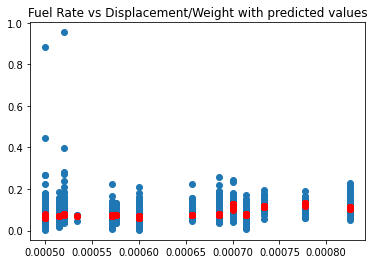

In [292]:
#plotting full model values
for i, feature in enumerate(features.keys()):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], preds, color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

In [293]:
preds = model.predict(X)

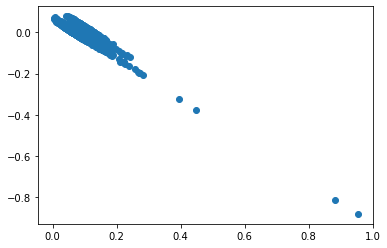

In [294]:
plt.scatter(y, preds-y)

# HEV 500 Regression

In [425]:
# cols = ["Aggressiveness", "Distance[km]", "Weight", "Displacement", "SpeedAverage", "SpeedVariance"]
# features = cols.copy()
# for i in range(len(cols)):
#     for j in range(i, len(cols)):
#         features.append(f"{cols[i]}*{cols[j]}")
#         features.append(f"{cols[i]}/{cols[j]}")

features = [
    "Aggressiveness",
    "Weight",
    "Displacement",
    "SpeedAverage",
    "Aggressiveness*Weight",
    "Aggressiveness*Displacement",
    "Weight*Weight",
    "Displacement/Weight",
]

In [426]:
X, y, features = transform_data(hev_500_data, features)

In [427]:
X[np.isnan(X)] = 0
X[X==float('inf')]=0

In [428]:
X.shape

(501, 8)

In [429]:
model = LinearRegression().fit(X,y)

In [430]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(features.keys(), model.coef_)):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_)])
for feature, i in zip(features.keys(), (impact*100)/impact.sum()):
    if i >=1: print(f"{feature}: {i}") 

Impact = MEAN * Coef
Aggressiveness: 0.041670319875125636
Weight: 0.02826655310167724
Displacement: 0.14745868521826314
SpeedAverage: 0.0017566845794173662
Aggressiveness*Weight: -0.01451272221885481
Aggressiveness*Displacement: 0.007789550219374173
Weight*Weight: -0.05355550715161292
Displacement/Weight: -0.11697178742367138
========= PERCENTAGES =========
Aggressiveness: 10.114601879284168
Weight: 6.861116784797619
Displacement: 35.7925232898376
Aggressiveness*Weight: 3.522660921928317
Aggressiveness*Displacement: 1.890751007522062
Weight*Weight: 12.999483443012267
Displacement/Weight: 28.392464095408567


In [431]:
# now lets compute r^2:
# WOW WE have an almost 0 impact on r^2 -- surprising
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()
print(r_2)

0.46593219562331234


In [438]:
for f, i in features.items():
    print(f"{f} : {model.coef_[i]}")

Aggressiveness : 8.305099904519205e-06
Weight : 8.848199377657168e-06
Displacement : 0.07919897222807658
SpeedAverage : 3.855309790887279e-05
Aggressiveness*Weight : -9.092434476952251e-10
Aggressiveness*Displacement : 8.42973015372515e-07
Weight*Weight : -5.1690620975693444e-09
Displacement/Weight : -203.88710307609603


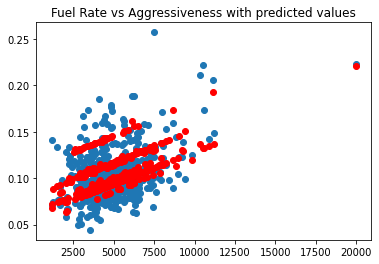

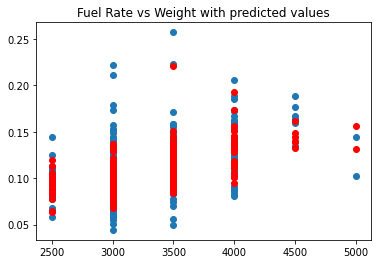

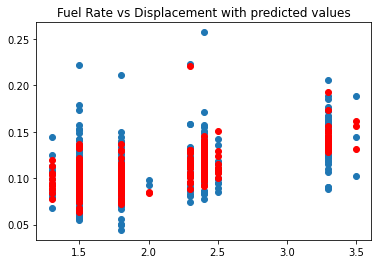

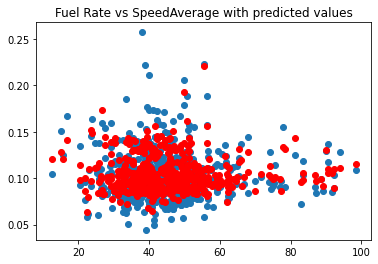

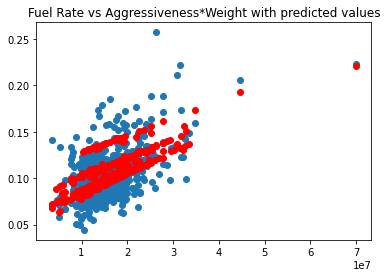

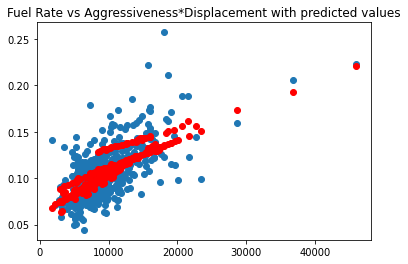

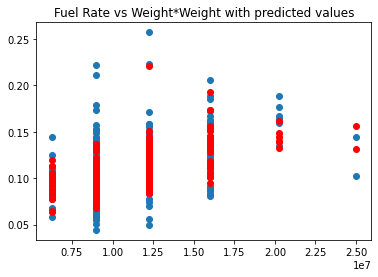

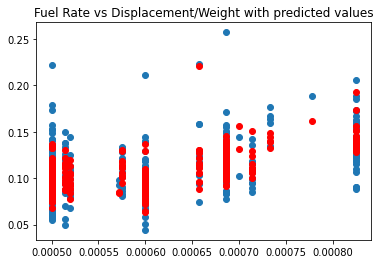

In [377]:
#plotting full model values
for i, feature in enumerate(features.keys()):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], preds, color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

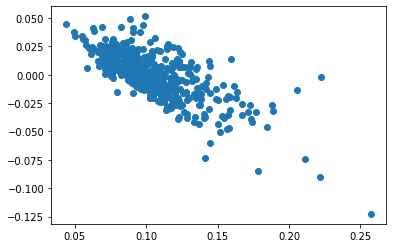

In [378]:
preds = model.predict(X)
plt.scatter(y, preds-y)

# ICE Regression

In [445]:
feats = [
    "Weight",
    "Displacement",
    "Aggressiveness",
    "SpeedAverage",
    "Aggressiveness*SpeedAverage",
    "Aggressiveness*Weight",
    "Aggressiveness*Displacement",
    "Displacement/Weight"
]
# cols = ["Aggressiveness", "Distance[km]", "Weight", "Displacement", "SpeedAverage", "SpeedVariance", "Air Temperature[F]", "Precipitation Level[mm]"]
# feats = cols.copy()
# for i in range(len(cols)):
#     for j in range(i, len(cols)):
#         feats.append(f"{cols[i]}*{cols[j]}")
#         feats.append(f"{cols[i]}/{cols[j]}")

X,y,feats = transform_data(ice_data, feats)
X[np.isnan(X)] = 0
X[X==float('inf')]=0
X[X== -float('inf')] = 0
ice_mod = LinearRegression().fit(X,y)



In [441]:
# now lets compute r^2:
# WOW WE have an almost 0 impact on r^2 -- surprising
preds = ice_mod.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()
print(r_2)

0.6207119301944473


In [442]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(feats.keys(), ice_mod.coef_)):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(ice_mod.coef_)])
for feature, i in zip(feats.keys(), (impact*100)/impact.sum()):
    print(f"{feature}: {i}")

Impact = MEAN * Coef
Weight: -0.06148706707455573
Displacement: 0.10527404404952317
Aggressiveness: 0.009362383536592847
SpeedAverage: -0.0017876434187791125
Aggressiveness*SpeedAverage: 0.0024450518421822577
Aggressiveness*Weight: 0.03025442558137625
Aggressiveness*Displacement: 0.020738717048870738
Displacement/Weight: -0.05286790493419801
========= PERCENTAGES =========
Weight: 21.633827567396427
Displacement: 37.039992711448356
Aggressiveness: 3.2940942004094484
SpeedAverage: 0.6289707952237336
Aggressiveness*SpeedAverage: 0.8602757045311246
Aggressiveness*Weight: 10.644824307272431
Aggressiveness*Displacement: 7.296783696972844
Displacement/Weight: 18.601231016745654


In [449]:
print('{')
for f, i in feats.items():
    print(f"'{f}' : {ice_mod.coef_[i]}")
print('}')

{
'Weight' : -1.8269039270731345e-05
'Displacement' : 0.042004106394102514
'Aggressiveness' : 1.7996834250139968e-06
'SpeedAverage' : -4.536430255501289e-05
'Aggressiveness*SpeedAverage' : 1.1924252555816587e-08
'Aggressiveness*Weight' : 1.7248847663015128e-09
'Aggressiveness*Displacement' : 1.590797867468572e-06
'Displacement/Weight' : -71.6318742731985
}


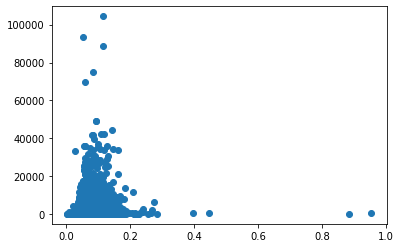

In [366]:
plt.scatter(y, y-preds)

# JUNK RANDOM STATS

In [32]:
ice_data

,TripId,TripId_raw,VehId,Aggressivity,Aggressiveness,Distance[km],Fuel Consumed[L],Fuel Rate[gpm],Weight,Displacement,SpeedAverage,SpeedVariance,Air Temperature[F],Precipitation Level[mm]
0,0,2265,123,475.645508,5748.696207,9.225222,0.895646,0.097087,2500.0,1.8,46.423729,147.494133,6.40,0.0
1,1,1239,135,269.540959,6372.966896,2.223611,0.441901,0.198731,3500.0,2.5,40.748170,447.766401,-6.47,0.0
2,4,2263,575,266.112770,5665.167276,6.323556,1.008958,0.159556,4000.0,2.4,32.929095,247.070941,1.52,0.0
3,7,1681,522,552.585767,5891.611649,2.743222,0.344075,0.125427,3000.0,2.4,33.915000,447.276871,8.92,0.0
4,8,1375,250,529.245807,5535.915731,4.683417,0.937469,0.200168,5500.0,5.3,33.196768,319.067811,12.23,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11798,17725,4334,597,566.123854,4290.373247,20.196611,2.288133,0.113293,3000.0,2.0,39.397884,630.252538,19.54,0.0
11799,17729,136,596,512.367166,5998.216793,2.710472,0.486187,0.179373,NaN,3.0,52.073944,448.542216,12.39,2.4
11800,17733,293,575,577.111615,5655.476501,1.663167,0.253618,0.152491,4000.0,2.4,38.972603,574.647520,16.68,0.0
11801,17735,1957,265,395.484703,5470.781309,9.977917,1.736937,0.174078,4000.0,3.0,38.995675,552.617297,22.49,0.0


In [408]:
features = [
    'Aggressiveness',
    'Weight',
    'Displacement',
    'SpeedAverage',
    'Aggressiveness*SpeedAverage',
    'Aggressiveness*Weight',
    'Aggressiveness*Displacement',
    'Displacement/Weight'
]

X, y, features = transform_data(ice_data, features)

In [409]:
features

{'Aggressiveness': 0,
 'Weight': 1,
 'Displacement': 2,
 'SpeedAverage': 3,
 'Aggressiveness*SpeedAverage': 4,
 'Aggressiveness*Weight': 5,
 'Aggressiveness*Displacement': 6,
 'Displacement/Weight': 7}

In [410]:
model = LinearRegression().fit(X,y)

In [411]:
real_fuel_consumption = (y * ice_data['Distance[km]']).sum()

In [412]:
real_fuel_consumption # in gallons

8040.246909945503

In [413]:
X[:,0] = min(X[:,0])
smallest_fuel_consumption = (model.predict(X)*ice_data['Distance[km]']).sum()

In [414]:
features = [
    'Aggressiveness',
    'Weight',
    'Displacement',
    'SpeedAverage',
    'Aggressiveness*SpeedAverage',
    'Aggressiveness*Weight',
    'Aggressiveness*Displacement',
    'Displacement/Weight'
]

X, y, features = transform_data(ice_data, features)

In [415]:
X[:,0] = max(X[:,0])

In [416]:
max_fuel_consumption = (model.predict(X) * ice_data['Distance[km]']).sum()

In [417]:
max_fuel_consumption # in gallons

10825.521243749768

In [418]:
X[:, 0] = 0

In [419]:
min_fuel_consumption = (model.predict(X) * ice_data['Distance[km]']).sum()

In [420]:
min_fuel_consumption

7513.78075266454

In [421]:
# percent delta:
(max_fuel_consumption - min_fuel_consumption) / max_fuel_consumption

0.30591972585128846

In [422]:
np.quantile(ice_data["Aggressiveness"], .10)

3377.437575386198

In [423]:
X[:,0] = 3377.437575386198
tenth_percentile = (model.predict(X) * ice_data['Distance[km]']).sum()

In [424]:
print("All values in gallons:")
print(f"Real Fuel Consumption: {real_fuel_consumption}, Aggressiveness = {5202.2}")
print(f"Maximum Fuel Consumption: {max_fuel_consumption}, Aggressiveness = {29848.9}")
print(f"Minimum Fuel Consumption: {min_fuel_consumption}, Aggressiveness = {0.0}")
print(f"Smallest Fuel Consumption: {smallest_fuel_consumption}, Aggressiveness = {347.0}")
print(f"10th Percentile Fuel Consumption: {tenth_percentile}, Aggressiveness = {3377.4}")



All values in gallons:
Real Fuel Consumption: 8040.246909945503, Aggressiveness = 5202.2
Maximum Fuel Consumption: 10825.521243749768, Aggressiveness = 29848.9
Minimum Fuel Consumption: 7513.78075266454, Aggressiveness = 0.0
Smallest Fuel Consumption: 7552.282037554995, Aggressiveness = 347.0
10th Percentile Fuel Consumption: 7888.508018691138, Aggressiveness = 3377.4


# HEV JUNK STATS: